# Assignment

We learned from the central limit theorem that the **mean** of a sample of size $n$ follows a normal distributon with center $\mu$ and variance $\sigma^2 / n$ where $\mu$ and $\sigma$ are the mean and variance of the population the sample was drawn from. And more importantly, the CTL holds **regardless of the distribution of the population** itelf as long as the sample size is large enough. So this leads to another question? What if we wanted to estimate the distribution of *some other statistic* besides the sample mean? For example, can we draw a similar conclusion about the distribution of the **sample median**? What about the distribution of the **sample variance**? Unfortunately, the CLT only applies to the sample mean, and finding the distribution of any other statistic is not that straight-forward. The CLT is like a mathematical guaratee, but we usually cannot make a similar guarantee with other statistics. So instead we can use computational methods to estimate the distribution of our statistic. One example of such computational method is **bootstrapping**.

The sampling techniques we learned in the lecture mainly deal with the problem of how to create smaller data in a way that it is representative of the larger population, and all of them were a form of sampling **without replacement**. **Bootstrapping** consists of **repeated sampling from data with replacement** (which means the same row of data can end of more than once in the sampled data). Bootstrapping is useful technique when we want to estimate the distribution of a statistic that would otherwise be hard to estimate.

Let's return to the bank marketing data from previous exercises:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

bank = pd.read_csv('bank-full.csv', delimiter = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


- Report the difference in the average balance for single vs married individuals in the data. <span style="color:red" float:right>[1 point]</span>

In [4]:
#Understanding the shape of the data
bank.shape

(45211, 17)

In [6]:
#Seeing nulls and datatypes
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Sources

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.groupby.html

https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas

https://betterprogramming.pub/visualize-charts-using-groupby-and-aggregate-python-functions-56454820a25c

https://towardsdatascience.com/comparing-different-ways-of-displaying-categorical-data-in-python-ed8fabfb6661

In [7]:
#I am going to make the assumption that 'divorced' individuals are not included in the bucket for 'single' individuals for the
#purpose of this question

bank['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [8]:
bank['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [22]:
bank_negative=bank[bank['balance']<0]

In [23]:
bank_negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3766 entries, 25 to 44964
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        3766 non-null   int64 
 1   job        3766 non-null   object
 2   marital    3766 non-null   object
 3   education  3766 non-null   object
 4   default    3766 non-null   object
 5   balance    3766 non-null   int64 
 6   housing    3766 non-null   object
 7   loan       3766 non-null   object
 8   contact    3766 non-null   object
 9   day        3766 non-null   int64 
 10  month      3766 non-null   object
 11  duration   3766 non-null   int64 
 12  campaign   3766 non-null   int64 
 13  pdays      3766 non-null   int64 
 14  previous   3766 non-null   int64 
 15  poutcome   3766 non-null   object
 16  y          3766 non-null   object
dtypes: int64(7), object(10)
memory usage: 529.6+ KB


In [24]:
bank_negative['balance'].describe()

count    3766.000000
mean     -317.677642
std       368.994983
min     -8019.000000
25%      -422.000000
50%      -230.000000
75%       -93.000000
max        -1.000000
Name: balance, dtype: float64

I am going to do two separate pathways, due to 3766 negative values, I will:

1) Remove the negative values

2) Keep the negative values

3) Compare

In [25]:
bank_remove = bank[bank['balance'] >= 0]

bank_remove['balance'].describe()

count     41445.000000
mean       1514.924744
std        3133.829437
min           0.000000
25%         146.000000
50%         542.000000
75%        1596.000000
max      102127.000000
Name: balance, dtype: float64

In [26]:
mean_marital_remove = bank_remove.groupby('marital', as_index=False)['balance'].mean()
mean_marital = bank.groupby('marital', as_index=False)['balance'].mean()

In [27]:
mean_marital_remove

,marital,balance
0,divorced,1363.636580
1,married,1581.508876
2,single,1433.177004


In [28]:
mean_marital

,marital,balance
0,divorced,1178.872287
1,married,1425.925590
2,single,1301.497654


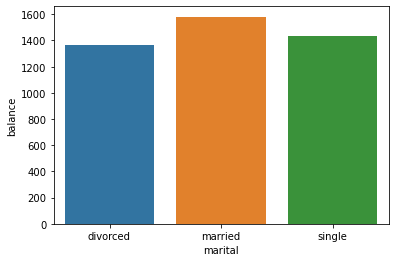

In [29]:
#Graph without the negative values

sns.barplot(x='marital', y='balance', data=mean_marital_remove);

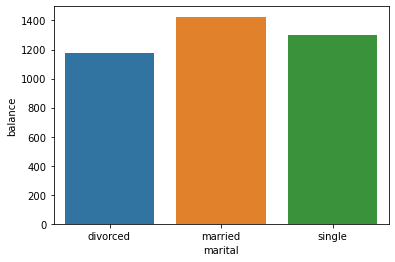

In [31]:
#Graph with the negative values

sns.barplot(x='marital', y='balance', data=mean_marital);

The difference in the median for single (1433) to married (1581) is not as much as I would have thought for the mean with the negative values removed. When looking at a graph with the negative values still there, it goes from 1304 (single) to 1425 (married). In both cases, the difference is "roughly" the same as there is a gap of between 120-150 dollars. 

Since balance is skewed to the right, maybe it's not such a good idea to compare averages for these two groups. So instead of the average, let's use the **median**.

- Report the difference in the median balance for single vs married individuals in the data. How does this compare to using the mean? <span style="color:red" float:right>[1 point]</span>

Will utilize the same approach as above, dividing out the negative values and also keeping them intact for comparison sake

In [32]:
median_marital_remove = bank_remove.groupby('marital', as_index=False)['balance'].median()
median_marital = bank.groupby('marital', as_index=False)['balance'].median()

In [51]:
median_marital

,marital,balance
0,divorced,458
1,married,574
2,single,522


In [33]:
median_marital_remove

,marital,balance
0,divorced,458
1,married,574
2,single,522


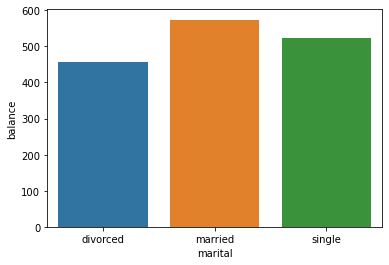

In [52]:
sns.barplot(x='marital', y='balance', data=median_marital);

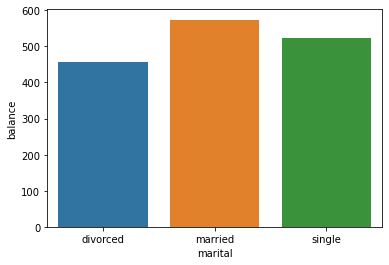

In [34]:
sns.barplot(x='marital', y='balance', data=median_marital_remove);

The difference between single and married individuals in the mean is not too much, only about 50 Dollars (Single - 522 to Married - 574). What I think is pretty important to note is that the median handles for the negative values that I had to remove to get the mean. Median is a more robust way of handling outliers.

But what is the distribution of the above statistics?

- In the case of the mean, we could rely on the CLT to answer that, assuming that we know the mean and variance of balance for single and married individuals **in the population** (our data is the sample).
- In the case of the median, we cannot rely on the CLT, so we will use bootstrapping to estimate the distribution.

1. Take a bootstrap sample from the data. You can use the `sample` method to do this. Recall that a bootstrap sample is a sample **with replacement**. Your bootstrap sample should have the same size (number of rows) as the data. <span style="color:red" float:right>[5 point]</span>
https://www.journaldev.com/45580/bootstrap-sampling-in-python
https://towardsdatascience.com/bootstrapping-using-python-and-r-b112bb4a969e
1. Find the difference between the median bank balances for single vs. married individuals in the bootstrap sample. We will refer to this as the **bootstrap estimate**. <span style="color:red" float:right>[2 point]</span>
1. Repeat steps 1 and 2 over 1000 iterations, and at the end of each iteration store the bootstrap estimate into a list we call `bootstrap_estimates`. <span style="color:red" float:right>[2 point]</span>

Sources and Scratch

https://datascience.stackexchange.com/questions/80048/bootstrap-clarification-for-datasets-with-multiple-columns

https://www.geeksforgeeks.org/python-random-sample-function/

https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html

https://pynative.com/python-random-sample/

import numpy as np
import random
 
x = np.random.normal(loc= 300.0, size=1000)
print(np.mean(x))

bootstrap_estimates = []
n_iters = 1000

for i in range(n_iters):
    y = random.sample(bank['balance'].tolist(), n_iters)
    avg = np.mean(y)
    bootstrap_estimates.append(avg)

#your code goes here


#For storing the bootstrap look at the reading - pgs 5 and on

print(np.mean(bootstrap_estimates))

type(bootstrap_estimates)

bootstrap_estimates

1. Take a bootstrap sample from the data. You can use the `sample` method to do this. Recall that a bootstrap sample is a sample **with replacement**. Your bootstrap sample should have the same size (number of rows) as the data. <span style="color:red" float:right>[5 point]

In [5]:
n_balance = bank['balance'].sum()#Creating a list for the bootstrap sample to run over

bootstrap_sample = bank.sample(n=n_balance, replace=True) #Making sure the bootstrapped sample has the same size as the n_balance

In [6]:
#

repeats = bootstrap_sample['marital'].value_counts()
repeats.head()

married     37077449
single      17419265
divorced     7092968
Name: marital, dtype: int64

In [44]:
bootstrap_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61589682 entries, 22665 to 32058
Data columns (total 17 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   age        int64 
 1   job        object
 2   marital    object
 3   education  object
 4   default    object
 5   balance    int64 
 6   housing    object
 7   loan       object
 8   contact    object
 9   day        int64 
 10  month      object
 11  duration   int64 
 12  campaign   int64 
 13  pdays      int64 
 14  previous   int64 
 15  poutcome   object
 16  y          object
dtypes: int64(7), object(10)
memory usage: 8.3+ GB


2. Find the difference between the median bank balances for single vs. married individuals in the bootstrap sample. We will refer to this as the **bootstrap estimate**. <span style="color:red" float:right>[2 point]

In [7]:
bootstrap_estimate = bootstrap_sample.groupby('marital', as_index=False)['balance'].median()

bootstrap_estimate

,marital,balance
0,divorced,348
1,married,478
2,single,437


In the calculation above, the difference was from 522 (Single), to 574 (Married) while the bootstrap returned 437 (Single), to 477 (Married)

3. Repeat steps 1 and 2 over 1000 iterations, and at the end of each iteration store the bootstrap estimate into a list we call `bootstrap_estimates`. <span style="color:red" float:right>[2 point]

In [58]:
#sns.scatterplot(x='marital',y='balance', data=bootstrap_estimate);

- Display the distribution of the 1000 bootstrap estimates we found. Does the distribution of the difference in medians appear to be symmetric? <span style="color:red" float:right>[2 point]</span>

In [59]:
#sns.displot(x=bootstrap_estimate['balance'],bins=100, height=6, aspect=2.0);

- What is its standard deviations? <span style="color:red" float:right>[1 point]</span>

In [ ]:
## your code goes here

So we now have not only the difference in median balance between the two groups, but we also have a measure of how uncertain this estimate is, based on bootrapping. 

# End of assignment